In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [7]:
df = pd.read_parquet("../features/ml_features.parquet")
print(df.shape)
print(df.columns.to_list())

(116352, 53)
['DESYNPUF_ID', 'sex', 'birth_date', 'race', 'death_date', 'chronic_count_2008', 'year', 'inpatient_num_claims', 'inpatient_total_payment', 'inpatient_primary_payer_amt', 'inpatient_total_deductible', 'inpatient_total_coinsurance', 'inpatient_total_blood_deductible', 'inpatient_total_util_days', 'num_unique_inpatient_providers', 'num_unique_inpatient_attending', 'num_unique_inpatient_operating', 'num_unique_inpatient_other', 'num_unique_drg', 'num_unique_inpatient_dx', 'num_unique_inpatient_proc', 'num_unique_inpatient_hcpcs', 'outpatient_num_claims', 'outpatient_total_payment', 'outpatient_primary_payer_amt', 'outpatient_total_deductible', 'outpatient_total_coinsurance', 'outpatient_total_blood_deductible', 'num_unique_outpatient_providers', 'num_unique_outpatient_attending', 'num_unique_outpatient_operating', 'num_unique_outpatient_other', 'num_unique_outpatient_dx', 'num_unique_outpatient_admit_dx', 'num_unique_outpatient_proc', 'num_unique_outpatient_hcpcs', 'carrier_n

In [8]:
selected_features = [
    'inpatient_total_payment', 'inpatient_total_util_days', 'num_unique_inpatient_dx',
    'outpatient_total_payment', 'carrier_total_payment', 'pde_num_prescriptions',
    'pde_total_drug_cost', 'chronic_count_2008', 'num_unique_outpatient_dx',
    'total_spending', 'sex', 'race'
]

# Filter and preprocess
X_raw = df[selected_features].copy()

# Encode categorical features
X_raw['sex'] = X_raw['sex'].map({'M': 1, 'F': 0})
X_raw['race'] = X_raw['race'].fillna(0).astype(int)

# Fill missing values
X_raw = X_raw.fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Step 1: PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Step 2: KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 3: Attach cluster labels to original dataframe
df['risk_cluster'] = cluster_labels


In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define a proxy target: members with high total spending
threshold = df['total_spending'].quantile(0.90)
df['target_deterioration'] = (df['total_spending'] > threshold).astype(int)

# Prepare data
X = df[selected_features]
y = df['target_deterioration']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBClassifier(n_estimators=100, max_depth=4, random_state=42)
model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [13]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test set
y_pred = model.predict(X_test)

# Print accuracy and full classification report
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.9979803188517897

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20944
           1       0.99      0.99      0.99      2327

    accuracy                           1.00     23271
   macro avg       0.99      1.00      0.99     23271
weighted avg       1.00      1.00      1.00     23271



 97%|=================== | 22526/23271 [00:13<00:00]       

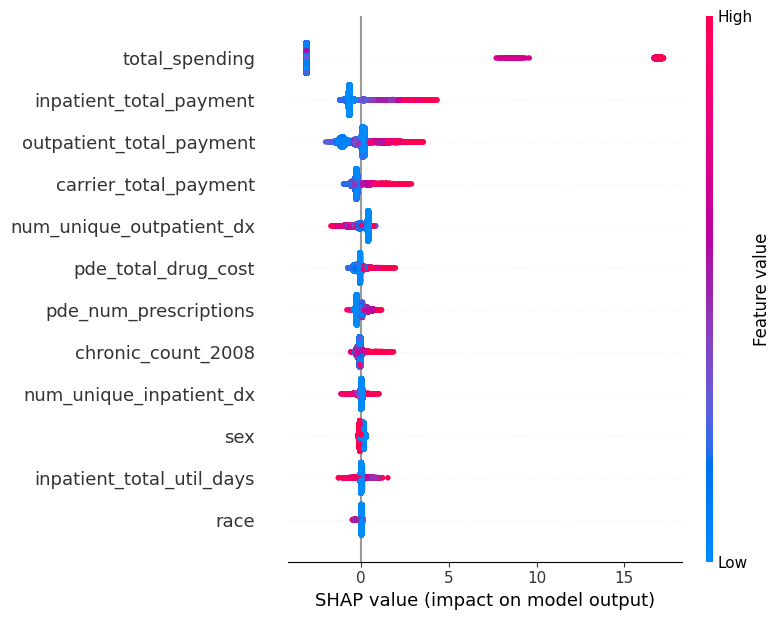

In [14]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Visualize global importance
shap.summary_plot(shap_values, X_test, feature_names=selected_features)


In [15]:
import numpy as np
import pandas as pd

# Get mean absolute SHAP values across all test samples
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create a ranked DataFrame
importance_df = pd.DataFrame({
    'feature': selected_features,
    'mean_abs_shap': shap_importance
}).sort_values(by='mean_abs_shap', ascending=False)

# Display top features
print(importance_df)


                      feature  mean_abs_shap
9              total_spending       4.498120
0     inpatient_total_payment       0.851996
3    outpatient_total_payment       0.642847
4       carrier_total_payment       0.437541
8    num_unique_outpatient_dx       0.326228
6         pde_total_drug_cost       0.237664
5       pde_num_prescriptions       0.202905
7          chronic_count_2008       0.156509
2     num_unique_inpatient_dx       0.084003
10                        sex       0.083871
1   inpatient_total_util_days       0.079874
11                       race       0.030332


In [17]:
import numpy as np
import pandas as pd

# Predict risk scores
df['risk_score'] = model.predict_proba(df[selected_features])[:, 1]

# Assign risk tiers (quantile-based)
df['risk_tier'] = pd.qcut(df['risk_score'], q=5, labels=[1, 2, 3, 4, 5])

# Map intervention cost per tier
intervention_costs = {1: 0, 2: 100, 3: 300, 4: 500, 5: 1000}
# Ensure intervention_cost is numeric
df['intervention_cost'] = df['intervention_cost'].astype(float)

# Now calculate ROI safely



# Estimate expected savings (assume 20% avoidable cost)
df['expected_savings'] = df['risk_score'] * df['total_spending'] * 0.2

# Calculate ROI
df['roi'] = df['expected_savings'] - df['intervention_cost']


In [18]:
df['roi']

0          -499.984676
1          -499.985780
2         12671.936484
3           -99.999357
4          -299.998551
              ...     
116347      -99.999163
116348      -99.999855
116349     -499.997301
116350     -500.000000
116351     -999.913257
Name: roi, Length: 116352, dtype: float64

In [89]:
def generate_member_risk_json(
    member_index: int,
    member_row: pd.Series,
    scaler: StandardScaler,
    pca_model,
    shap_explainer,
    cluster_models: dict,
    cluster_features: dict
) -> dict:
    """
    Generates a risk JSON for a single member using unsupervised clustering and SHAP explanations.
    """

    # Step 1: Prepare inputs for PCA + SHAP
    features_pca = scaler.feature_names_in_.tolist()
    X_pca_input = pd.DataFrame([member_row])[features_pca].fillna(0)
    X_scaled = scaler.transform(X_pca_input)
    X_pca = pca_model.transform(X_scaled)

    # Step 2: Assign anchor cluster from 90-day model
    features_90d = cluster_features['90_day']
    X_90d_input = pd.DataFrame([member_row])[features_90d].fillna(0)
    cluster_main = int(cluster_models['90_day'].predict(X_90d_input)[0])

    # Step 3: Window-wise cluster scoring
    risk_scores = {}
    risk_tiers = {}
    for window, model in cluster_models.items():
        features = cluster_features[window]
        X_window = pd.DataFrame([member_row])[features].fillna(0)
        cluster_id = int(model.predict(X_window)[0])
        score = float(np.linalg.norm(model.cluster_centers_[cluster_id]))
        risk_scores[window] = round(score, 2)

        # Tiering logic
        if score < 5:
            tier = 1
        elif score < 10:
            tier = 2
        elif score < 15:
            tier = 3
        elif score < 20:
            tier = 4
        else:
            tier = 5
        risk_tiers[window] = tier

    # Step 4: SHAP top features
    shap_values = shap_explainer(X_pca_input)
    shap_dict = dict(sorted(
        zip(X_pca_input.columns, shap_values.values[0]),
        key=lambda x: abs(x[1]), reverse=True
    )[:5])
    shap_dict = {k: round(v, 3) for k, v in shap_dict.items()}

    # Step 5: Narrative generation
    narratives = {
        '30_day': "Acute utilization spike—likely inpatient or pharmacy driven.",
        '60_day': "Sustained multi-claim activity and diagnostic complexity.",
        '90_day': "Chronic burden and systemic fragmentation—long-term deterioration."
    }

    # Step 6: ROI logic
    tier_90 = risk_tiers['90_day']
    intervention_costs = {1: 0, 2: 100, 3: 300, 4: 500, 5: 1000}
    intervention_cost = intervention_costs[tier_90]
    expected_savings = round(risk_scores['90_day'] * member_row.get('total_spending', 0) * 0.2)
    eligible = expected_savings > intervention_cost
    recommended_action = "Care coordination + pharmacy review" if eligible else "Monitor only"

    return {
        "DESYNPUF_ID": member_row.get("DESYNPUF_ID", f"member_{member_index}"),
        "cluster": cluster_main,
        "risk_scores": risk_scores,
        "risk_tiers": risk_tiers,
        "narratives": narratives,
        "shap_top_features": shap_dict,
        "intervention_roi": {
            "eligible": eligible,
            "expected_savings": expected_savings,
            "recommended_action": recommended_action
        }
    }


In [57]:
features_30d = ['total_spending', 'inpatient_num_claims', 'outpatient_num_claims']
features_60d = features_30d + ['carrier_num_claims', 'pde_num_prescriptions']
features_90d = features_60d + ['inpatient_total_util_days', 'num_unique_drg', 'num_unique_inpatient_dx']


In [58]:
from sklearn.cluster import KMeans

def assign_clusters(df, features, n_clusters=3):
    available = [f for f in features if f in df.columns]
    X = df[available].fillna(0)
    model = KMeans(n_clusters=n_clusters, random_state=42)
    df_temp = df.copy()
    df_temp['risk_cluster'] = model.fit_predict(X)
    return df_temp, model


In [59]:
def label_deterioration(df_clustered, reference_feature='total_spending'):
    cluster_means = df_clustered.groupby('risk_cluster')[reference_feature].mean()
    high_risk_cluster = cluster_means.idxmax()
    df_clustered['target_deterioration'] = (df_clustered['risk_cluster'] == high_risk_cluster).astype(int)
    return df_clustered


In [60]:
df_30d, model_30d = assign_clusters(df, features_30d)
df_30d = label_deterioration(df_30d)

df_60d, model_60d = assign_clusters(df, features_60d)
df_60d = label_deterioration(df_60d)

df_90d, model_90d = assign_clusters(df, features_90d)
df_90d = label_deterioration(df_90d)


In [90]:
# Select one member row by index
member_index = 42
member_row = df.iloc[member_index]

# Extract raw features for clustering (exact order used during scaler/PCA fit)
features_kmeans = scaler.feature_names_in_.tolist()
X_kmeans_input = pd.DataFrame([member_row])[features_kmeans].fillna(0)
features_90d_kmeans = model_90d.feature_names_in_.tolist()
features_30d_kmeans = model_30d.feature_names_in_.tolist()
features_60d_kmeans = model_60d.feature_names_in_.tolist()

member_json = generate_member_risk_json(
    member_index=member_index,
    member_row=member_row,
    scaler=scaler,
    pca_model=pca,
    shap_explainer=explainer,
    cluster_models={
        '30_day': model_30d,
        '60_day': model_60d,
        '90_day': model_90d
    },
    cluster_features={
        '30_day': model_30d.feature_names_in_.tolist(),
        '60_day': model_60d.feature_names_in_.tolist(),
        '90_day': model_90d.feature_names_in_.tolist()
    }
)

import json
print(json.dumps(member_json, indent=2))


# Pretty-print the result
import json
print(json.dumps(member_json, indent=2))


{
  "DESYNPUF_ID": "004B364955271F56",
  "cluster": 0,
  "risk_scores": {
    "30_day": 6286.82,
    "60_day": 6283.05,
    "90_day": 6277.07
  },
  "risk_tiers": {
    "30_day": 5,
    "60_day": 5,
    "90_day": 5
  },
  "narratives": {
    "30_day": "Acute utilization spike\u2014likely inpatient or pharmacy driven.",
    "60_day": "Sustained multi-claim activity and diagnostic complexity.",
    "90_day": "Chronic burden and systemic fragmentation\u2014long-term deterioration."
  },
  "shap_top_features": {
    "carrier_total_payment": -0.3,
    "total_spending": -0.208,
    "sex": 0.183,
    "pde_num_prescriptions": 0.093,
    "inpatient_total_util_days": -0.087
  },
  "intervention_roi": {
    "eligible": true,
    "expected_savings": 21655892,
    "recommended_action": "Care coordination + pharmacy review"
  }
}
{
  "DESYNPUF_ID": "004B364955271F56",
  "cluster": 0,
  "risk_scores": {
    "30_day": 6286.82,
    "60_day": 6283.05,
    "90_day": 6277.07
  },
  "risk_tiers": {
    "30

In [50]:
print(df['year'].value_counts().sort_index())


year
2010    112754
Name: count, dtype: int64


In [56]:
print(df.columns.tolist())


['DESYNPUF_ID', 'sex', 'birth_date', 'race', 'death_date', 'chronic_count_2008', 'year', 'inpatient_num_claims', 'inpatient_total_payment', 'inpatient_primary_payer_amt', 'inpatient_total_deductible', 'inpatient_total_coinsurance', 'inpatient_total_blood_deductible', 'inpatient_total_util_days', 'num_unique_inpatient_providers', 'num_unique_inpatient_attending', 'num_unique_inpatient_operating', 'num_unique_inpatient_other', 'num_unique_drg', 'num_unique_inpatient_dx', 'num_unique_inpatient_proc', 'num_unique_inpatient_hcpcs', 'outpatient_num_claims', 'outpatient_total_payment', 'outpatient_primary_payer_amt', 'outpatient_total_deductible', 'outpatient_total_coinsurance', 'outpatient_total_blood_deductible', 'num_unique_outpatient_providers', 'num_unique_outpatient_attending', 'num_unique_outpatient_operating', 'num_unique_outpatient_other', 'num_unique_outpatient_dx', 'num_unique_outpatient_admit_dx', 'num_unique_outpatient_proc', 'num_unique_outpatient_hcpcs', 'carrier_num_claims', '

In [91]:
import joblib
joblib.dump(scaler, '../models/scaler.pkl')


['../models/scaler.pkl']

In [92]:
scaler.feature_names_in_.tolist()

['inpatient_total_payment',
 'inpatient_total_util_days',
 'num_unique_inpatient_dx',
 'outpatient_total_payment',
 'carrier_total_payment',
 'pde_num_prescriptions',
 'pde_total_drug_cost',
 'chronic_count_2008',
 'num_unique_outpatient_dx',
 'total_spending',
 'sex',
 'race']

In [98]:
joblib.dump(pca, '../models/pca_model.pkl')

['../models/pca_model.pkl']

In [94]:
pca.n_components_  # Confirm locked dimensionality


2

In [97]:
joblib.dump(explainer, '../models/shap_explainer.pkl')

['../models/shap_explainer.pkl']

In [99]:
model_30d.feature_names_in_.tolist()

['total_spending', 'inpatient_num_claims', 'outpatient_num_claims']

In [100]:
joblib.dump(model_60d, '../models/kmeans_60d.pkl')
joblib.dump(model_60d, '../models/kmeans_60d.pkl')
joblib.dump(model_90d, '../models/kmeans_90d.pkl')

['../models/kmeans_90d.pkl']

In [104]:
def write_all_model_schemas_to_txt(filename):
    with open(filename, 'w') as f:
        # Scaler
        f.write("🔹 Scaler\n")
        f.write(f"Model Type: {type(scaler).__name__}\n")
        f.write("Input Features:\n")
        for feat in scaler.feature_names_in_:
            f.write(f"  - {feat}\n")
        f.write("\n" + "-"*40 + "\n\n")

        # PCA
        f.write("🔹 PCA Model\n")
        f.write(f"Model Type: {type(pca).__name__}\n")
        f.write(f"Number of Components: {pca.n_components_}\n")
        f.write("Input Features: [Unavailable — fitted on array or transformed data]\n")
        f.write("\n" + "-"*40 + "\n\n")

        # SHAP Explainer
        f.write("🔹 SHAP Explainer\n")
        f.write(f"Model Type: {type(explainer).__name__}\n")
        if hasattr(explainer, 'explainer_type'):
            f.write(f"Explainer Type: {explainer.explainer_type}\n")
        f.write("Note: Trained on PCA-transformed data\n")
        f.write("\n" + "-"*40 + "\n\n")

        # KMeans Models
        for label, model in zip(['30-day', '60-day', '90-day'], [model_30d, model_60d, model_90d]):
            f.write(f"🔹 KMeans ({label})\n")
            f.write(f"Model Type: {type(model).__name__}\n")
            f.write(f"Number of Clusters: {model.n_clusters}\n")
            f.write("Input Features:\n")
            for feat in model.feature_names_in_:
                f.write(f"  - {feat}\n")
            f.write("\n" + "-"*40 + "\n\n")


In [105]:
write_all_model_schemas_to_txt('../models/model_schemas.txt')
